# MM High Risk - Evaluate Model
Multiple Myeloma (MM) is a type of bone marrow cancer. Treatment for MM involves combinations of drugs over multiple cycles. There is huge heterogeneity in treatment response with some individuals not responding to treatment and some patients responding well to treatment for some time before a relapse. A better characterization of patients who relapse early can influence the treatment options and combinations.

## Objective
Develop a machine learning model for predicting the risk of fast dying or relapsing of newly diagnosed MM patients.

## Import libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from pathlib import Path

In [2]:
# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# pandas show full output
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)

# add module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src import config
from src import preprocess
from src import model
from src import visual
from src import gene
from src import utils

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

## Evaluate model

Load training and testing data.

In [5]:
df_train = preprocess.load_training_data()
df_test = preprocess.load_testing_data()
df_train.head()

,D_Age,D_Gender,D_ISS,CYTO_predicted_feature_01,CYTO_predicted_feature_02,CYTO_predicted_feature_03,CYTO_predicted_feature_05,CYTO_predicted_feature_06,CYTO_predicted_feature_08,CYTO_predicted_feature_10,CYTO_predicted_feature_12,CYTO_predicted_feature_13,CYTO_predicted_feature_14,CYTO_predicted_feature_15,CYTO_predicted_feature_16,CYTO_predicted_feature_17,CYTO_predicted_feature_18,HR_FLAG,Entrez_1,Entrez_2,Entrez_3,Entrez_9,Entrez_10,Entrez_13,Entrez_14,Entrez_15,Entrez_16,Entrez_18,Entrez_19,Entrez_20,Entrez_21,Entrez_22,Entrez_23,Entrez_24,Entrez_25,Entrez_26,Entrez_27,Entrez_28,Entrez_29,Entrez_30,Entrez_32,Entrez_33,Entrez_34,Entrez_35,Entrez_36,Entrez_37,Entrez_38,Entrez_39,Entrez_40,Entrez_41,Entrez_43,Entrez_47,Entrez_48,Entrez_49,Entrez_50,Entrez_51,Entrez_52,Entrez_53,Entrez_54,Entrez_55,Entrez_56,Entrez_58,Entrez_59,Entrez_60,Entrez_70,Entrez_71,Entrez_72,Entrez_81,Entrez_86,Entrez_87,Entrez_88,Entrez_89,Entrez_90,Entrez_91,Entrez_92,Entrez_93,Entrez_94,Entrez_95,Entrez_97,Entrez_98,Entrez_100,Entrez_101,Entrez_102,Entrez_103,Entrez_104,Entrez_105,Entrez_107,Entrez_108,Entrez_109,Entrez_111,Entrez_112,Entrez_113,Entrez_114,Entrez_115,Entrez_116,Entrez_117,Entrez_118,Entrez_119,Entrez_120,Entrez_123,...,Entrez_252953,Entrez_252955,Entrez_2576,Entrez_26240,Entrez_26267,Entrez_2657,Entrez_26628,Entrez_27183,Entrez_27328,Entrez_284194,Entrez_284366,Entrez_2844,Entrez_286128,Entrez_29940,Entrez_29994,Entrez_3117,Entrez_3222,Entrez_3316,Entrez_344,Entrez_3690,Entrez_3742,Entrez_3753,Entrez_378108,Entrez_378948,Entrez_387104,Entrez_388389,Entrez_3963,Entrez_3987,Entrez_401428,Entrez_414245,Entrez_4253,Entrez_440574,Entrez_440895,Entrez_4701,Entrez_4714,Entrez_50858,Entrez_5098,Entrez_51124,Entrez_51263,Entrez_51326,Entrez_51643,Entrez_51735,Entrez_51750,Entrez_5296,Entrez_53916,Entrez_54949,Entrez_552900,Entrez_55308,Entrez_5683,Entrez_572558,Entrez_57335,Entrez_57497,Entrez_57501,Entrez_582,Entrez_58496,Entrez_5940,Entrez_60677,Entrez_6139,Entrez_641367,Entrez_641517,Entrez_642778,Entrez_645166,Entrez_64788,Entrez_65082,Entrez_653067,Entrez_65988,Entrez_6606,Entrez_6844,Entrez_727856,Entrez_728047,Entrez_728411,Entrez_728734,Entrez_731275,Entrez_7730,Entrez_79086,Entrez_79741,Entrez_80006,Entrez_805,Entrez_80829,Entrez_8190,Entrez_8293,Entrez_8302,Entrez_83864,Entrez_83986,Entrez_84220,Entrez_84342,Entrez_84619,Entrez_84672,Entrez_84673,Entrez_8490,Entrez_84976,Entrez_8509,Entrez_86614,Entrez_8778,Entrez_8926,Entrez_9570,Entrez_9692,Entrez_9720,Entrez_9768,Entrez_9797
0,53,Female,2.0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,5.537100,0.319986,0.0,1.326200,0.0,0.0,32.2357,1.077890,40.0047,0.370424,0.456427,0.832329,1.696350,4.58103,20.0967,0.002118,7.30377,0.038114,2.63084,0.019251,1.129040,17.5644,0.103975,0.000000,19.1865,0.176863,4.59999,241.2090,41.4961,5.35351,0.000000,0.000000,15.502500,22.1528,4.44696,0.011813,26.8060,8.71236,32.0205,9.20201,24.25310,0.037352,0.007352,0.169543,0.728360,872.290,0.000000,296.965,0.038783,39.9283,16.1697,0.536849,0.000000,0.000000,4.44569,1.62064,3.27488,1.91056,0.035025,11.51650,2.73428,15.02490,9.09920,14.76040,17.0488,109.2530,2.47428,0.000000,0.019648,0.000000,3.229060,0.026659,1.823080,15.26810,0.0,0.052030,0.000000,0.0,51.8207,0.255654,22.20760,6.583470,...,0.0,0.0,0.00000,0.558980,2.440529,0.025282,0.124154,16.634899,0.004964,0.461558,0.0,3.730470,1.410060,1.352189,4.215457,0.151257,0.0,0.010208,0.000000,0.845080,0.003399,0.046065,1.209968,0.0,0.000000,0.039299,0.000000,5.542835,2.315734,0.829441,7.42140,17.527550,0.046833,14.34540,32.917805,0.0,0.992782,11.871750,1.985060,3.223010,35.125510,1.623395,2.749050,4.048090,7.501123,12.981500,32.062850,5.159106,36.179935,0.0,0.808360,0.0,0.033320,2.966372,2.070388,0.0,0.131731,342.957695,0.011962,0.0,16.112854,1.529000,15.672136,2.158727,0.033352,1.300748,6.105335,24.937650,0.087259,0.822156,2.313015,0.006812,2.431810,0.379061,16.58383,0.865157,3.229735,74.69845,8.957061,0.024767,4.435979,0.000000,0.000000,4.214925,11.913600,3.979330,7.805535,

Split X and y columns.

In [6]:
X_train, y_train = preprocess.split_x_y(df_train)
X_test, y_test = preprocess.split_x_y(df_test)

## Baseline

In [7]:
model_date = '2022-11-13'

In [8]:
model_name = 'RF_baseline'
X_train_min = X_train[config.FEATURES_MINIMAL].copy()
X_test_min = X_test[config.FEATURES_MINIMAL].copy()

clf_rf_baseline = model.load_model(model_date, model_name)
clf_rf_baseline


Load model from: C:\projects\side_projects\mm_highrisk\models\model_RF_baseline_2022-11-13.joblib


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('ohe_nominal',
                                                                               OneHotEncoder(sparse=False),
                                                                               []),
                                                                              ('impute_ordinal',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['D_Age',
                                                                                'D_ISS']),
                                                                              ('impute_continuous',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Entrez_26147',
                                                                                'Entrez_7468'])])),
                                             ('clf',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_jobs=4,
                   param_distributions={'clf__bootstrap': [True, False],
                                        'clf__criterion': ['gini', 'entropy'],
                                        'clf__max_depth': range(2, 100, 5),
                                        'clf__max_features': ['sqrt', 'log2'],
                                        'clf__min_samples_leaf': range(2, 15, 2),
                                        'clf__min_samples_split': range(2, 15, 2),
                                        'clf__n_estimators': range(10, 1000, 50)},
                   scoring='average_precision', verbose=10)

Note: gene MMSET is also called NSD2

average_precision test data: 0.4781543692907255
roc_auc test data: 0.6269956458635704
balanced_accuracy test data: 0.5613207547169812

              precision    recall  f1-score   support

           0       0.72      0.62      0.67        53
           1       0.39      0.50      0.44        26

    accuracy                           0.58        79
   macro avg       0.56      0.56      0.55        79
weighted avg       0.61      0.58      0.59        79

best params: {'clf__n_estimators': 960, 'clf__min_samples_split': 14, 'clf__min_samples_leaf': 6, 'clf__max_features': 'sqrt', 'clf__max_depth': 62, 'clf__criterion': 'entropy', 'clf__bootstrap': True}


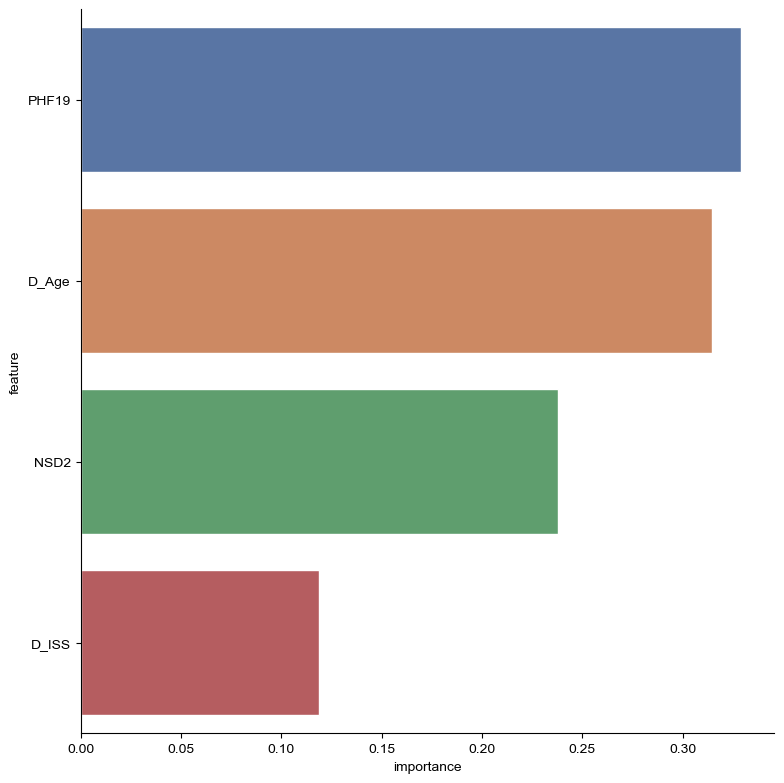

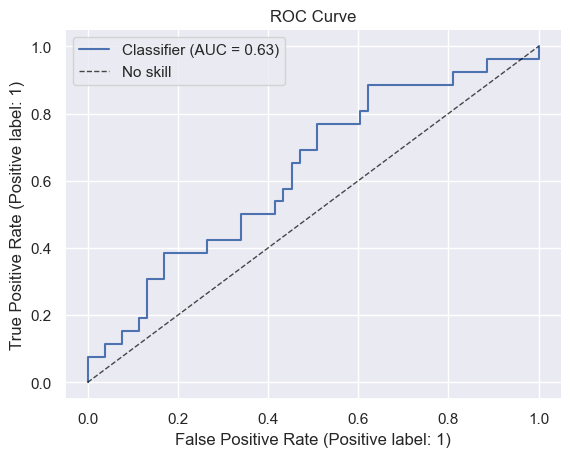

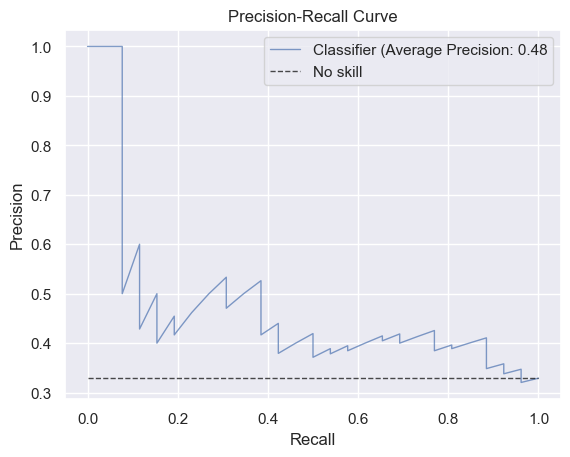

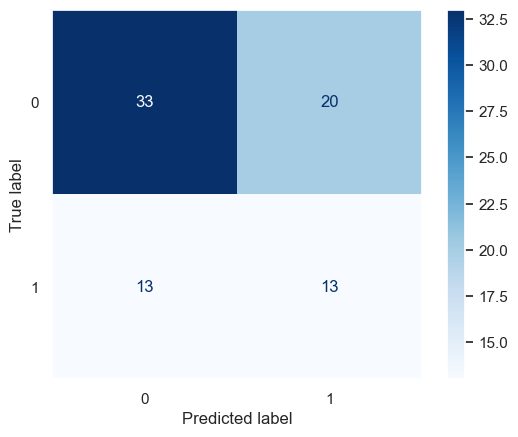

In [9]:
visual.model_evaluation_report(clf_rf_baseline, X_test, y_test)

In [10]:
model_name = 'XGB_baseline'
X_train_min = X_train[config.FEATURES_MINIMAL].copy()
X_test_min = X_test[config.FEATURES_MINIMAL].copy()

clf_xgb_baseline = model.load_model(model_date, model_name)
clf_xgb_baseline

Load model from: C:\projects\side_projects\mm_highrisk\models\model_XGB_baseline_2022-11-13.joblib


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('ohe_nominal',
                                                                               OneHotEncoder(sparse=False),
                                                                               []),
                                                                              ('impute_ordinal',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['D_Age',
                                                                                'D_ISS']),
                                                                              ('impute_continuous',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Entrez_26147',
                                                                                'Entrez_7468'])])),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            boos...
                   param_distributions={'clf__learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'clf__max_depth': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82,
       87, 92, 97]),
                                        'clf__n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   scoring='average_precision', verbose=10)

average_precision test data: 0.4291281014526167
roc_auc test data: 0.5043541364296081
balanced_accuracy test data: 0.522133526850508

              precision    recall  f1-score   support

           0       0.69      0.70      0.69        53
           1       0.36      0.35      0.35        26

    accuracy                           0.58        79
   macro avg       0.52      0.52      0.52        79
weighted avg       0.58      0.58      0.58        79

best params: {'clf__n_estimators': 260, 'clf__max_depth': 82, 'clf__learning_rate': 0.4}


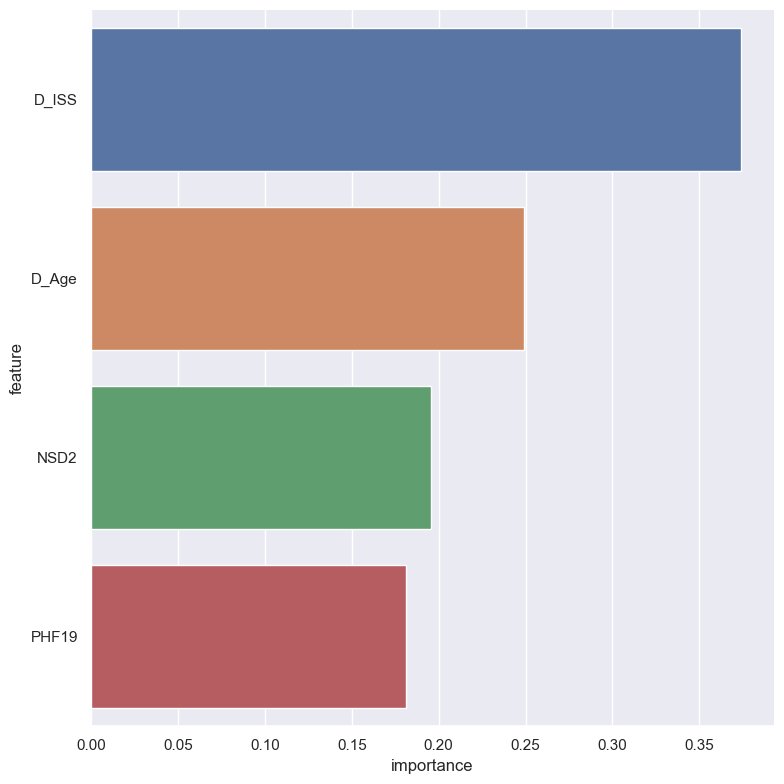

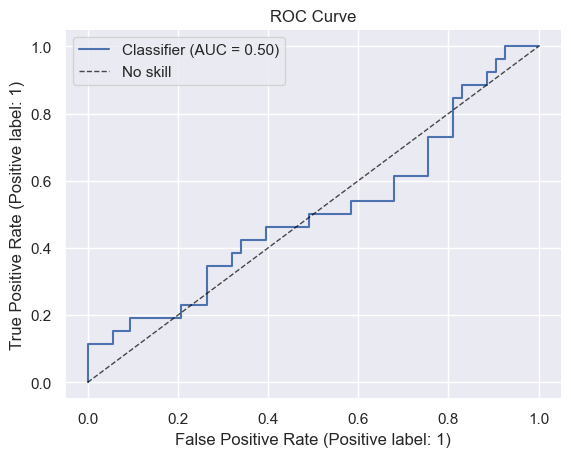

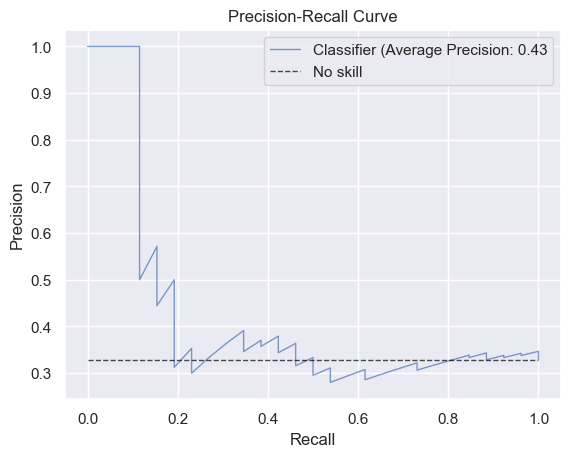

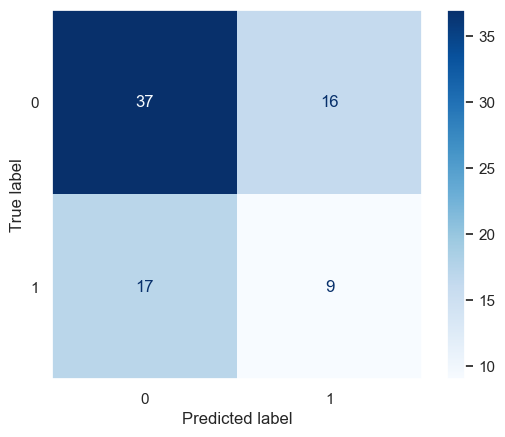

In [11]:
visual.model_evaluation_report(clf_xgb_baseline, X_test, y_test)

## Feature selection pipeline

In [12]:
model_name = 'RF_select'
clf_rf_select = model.load_model(model_date, model_name)
clf_rf_select

Load model from: C:\projects\side_projects\mm_highrisk\models\model_RF_select_2022-11-13.joblib


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(memory='C:\\Users\\DKN190~1.515\\AppData\\Local\\Temp\\tmp4uw6cgvc',
                                      steps=[('preprocess',
                                              ColumnTransformer(transformers=[('ohe_nominal',
                                                                               OneHotEncoder(sparse=False),
                                                                               ['D_Gender']),
                                                                              ('impute_ordinal',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['D_Age',
                                                                                'D_ISS']),
                                                                              ('impute_continuous',
                                                                               SimpleImputer(strategy='median'...
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_jobs=4,
                   param_distributions={'clf__bootstrap': [True, False],
                                        'clf__criterion': ['gini', 'entropy'],
                                        'clf__max_depth': range(2, 100, 5),
                                        'clf__max_features': ['sqrt', 'log2'],
                                        'clf__min_samples_leaf': range(2, 15, 2),
                                        'clf__min_samples_split': range(2, 15, 2),
                                        'clf__n_estimators': range(10, 1000, 50)},
                   scoring='average_precision', verbose=10)

average_precision test data: 0.5368288067509762
roc_auc test data: 0.7126269956458635
balanced_accuracy test data: 0.6843251088534108

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        53
           1       0.61      0.54      0.57        26

    accuracy                           0.73        79
   macro avg       0.70      0.68      0.69        79
weighted avg       0.73      0.73      0.73        79

best params: {'clf__n_estimators': 710, 'clf__min_samples_split': 6, 'clf__min_samples_leaf': 6, 'clf__max_features': 'sqrt', 'clf__max_depth': 77, 'clf__criterion': 'gini', 'clf__bootstrap': False}


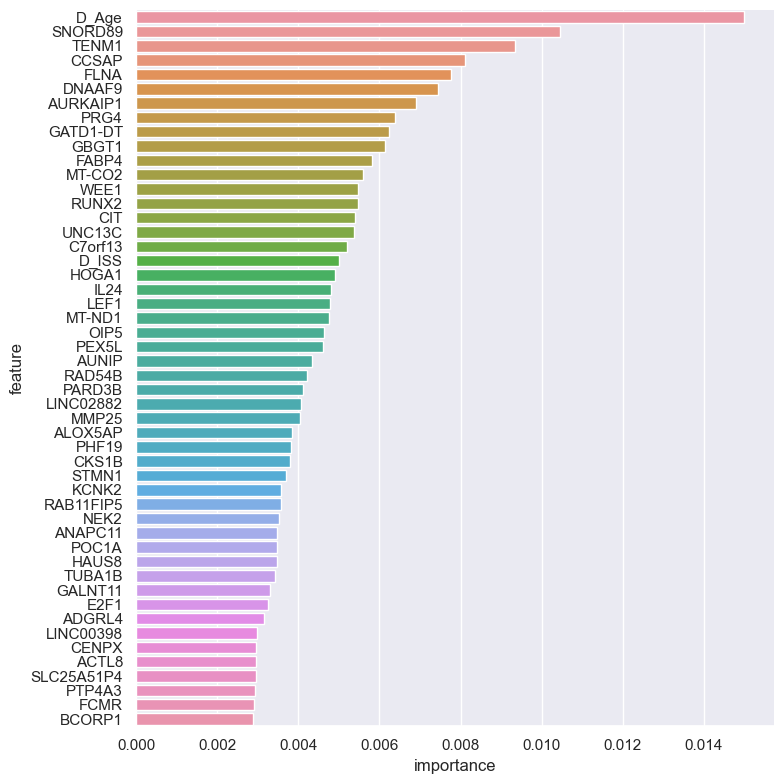

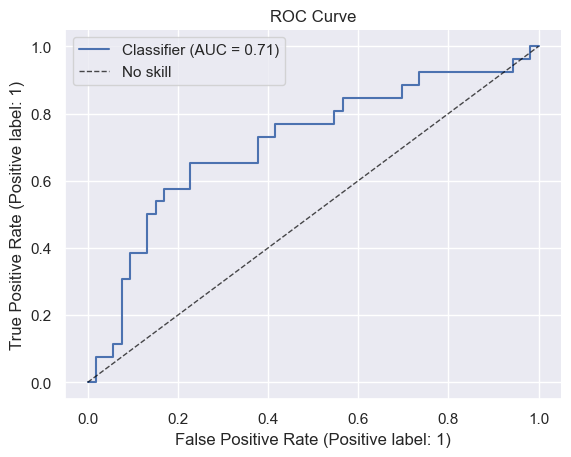

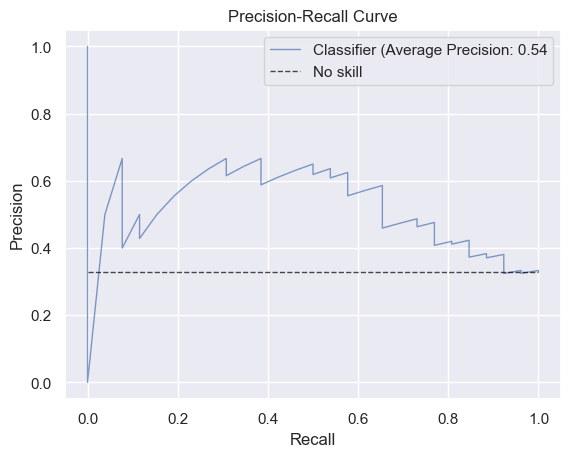

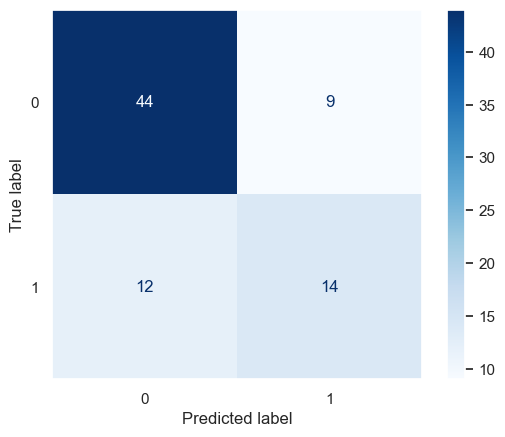

In [13]:
visual.model_evaluation_report(clf_rf_select, X_test, y_test)

In [14]:
model_name = 'XGB_select'
clf_xgb_select = model.load_model(model_date, model_name)
clf_xgb_select

Load model from: C:\projects\side_projects\mm_highrisk\models\model_XGB_select_2022-11-13.joblib


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(memory='C:\\Users\\DKN190~1.515\\AppData\\Local\\Temp\\tmpccrhumnz',
                                      steps=[('preprocess',
                                              ColumnTransformer(transformers=[('ohe_nominal',
                                                                               OneHotEncoder(sparse=False),
                                                                               ['D_Gender']),
                                                                              ('impute_ordinal',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['D_Age',
                                                                                'D_ISS']),
                                                                              ('impute_continuous',
                                                                               SimpleImputer(strategy='median'...
                   param_distributions={'clf__learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'clf__max_depth': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82,
       87, 92, 97]),
                                        'clf__n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   scoring='average_precision', verbose=10)

average_precision test data: 0.47815009234166383
roc_auc test data: 0.6545718432510885
balanced_accuracy test data: 0.6077648766328012

              precision    recall  f1-score   support

           0       0.74      0.79      0.76        53
           1       0.50      0.42      0.46        26

    accuracy                           0.67        79
   macro avg       0.62      0.61      0.61        79
weighted avg       0.66      0.67      0.66        79

best params: {'clf__n_estimators': 510, 'clf__max_depth': 12, 'clf__learning_rate': 0.5}


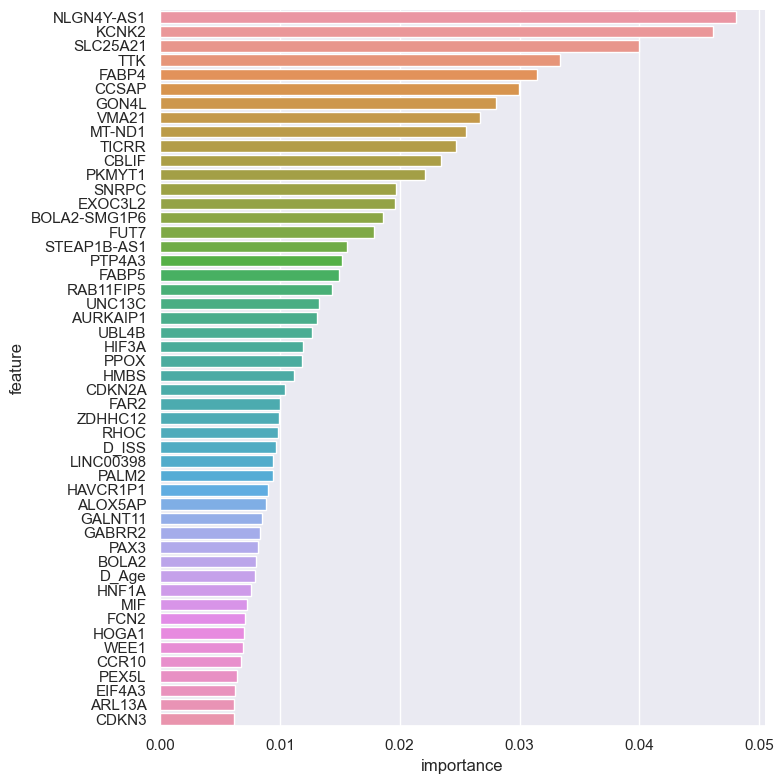

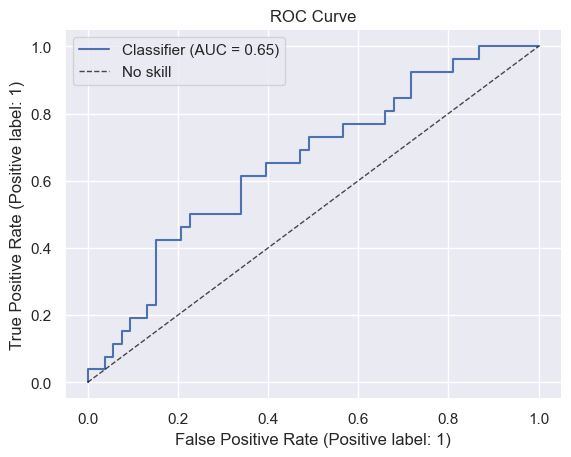

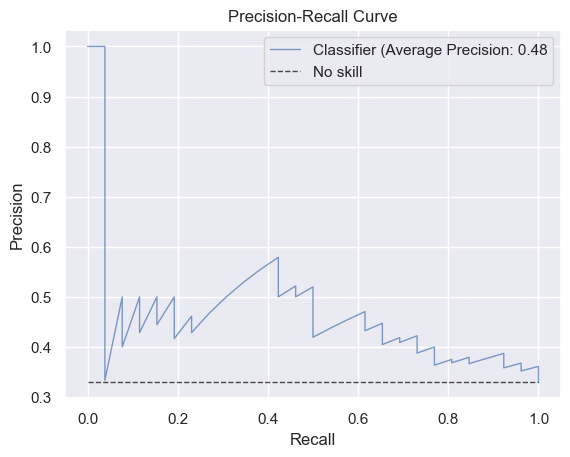

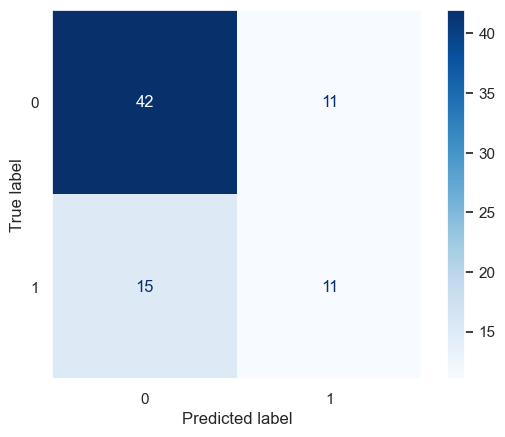

In [16]:
visual.model_evaluation_report(clf_xgb_select, X_test, y_test)

## Dimensionality reduction

In [17]:
model_name = 'RF_dimred'
clf_rf_dimred = model.load_model(model_date, model_name)
clf_rf_dimred

Load model from: C:\projects\side_projects\mm_highrisk\models\model_RF_dimred_2022-11-13.joblib


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('ohe_nominal',
                                                                               OneHotEncoder(sparse=False),
                                                                               ['D_Gender']),
                                                                              ('impute_ordinal',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['D_Age',
                                                                                'D_ISS']),
                                                                              ('pca_continuous',
                                                                               Pipeline(steps=[('remove_constant',
                                                                                                VarianceThreshold(threshold=0)),
                                                                                               ('impute_continuous',
                                                                                                SimpleImputer(...
                   param_distributions={'clf__bootstrap': [True, False],
                                        'clf__criterion': ['gini', 'entropy'],
                                        'clf__max_depth': range(2, 100, 5),
                                        'clf__max_features': ['sqrt', 'log2'],
                                        'clf__min_samples_leaf': range(2, 15, 2),
                                        'clf__min_samples_split': range(2, 15, 2),
                                        'clf__n_estimators': range(10, 1000, 50),
                                        'preprocess__pca_continuous__pca__n_components': range(5, 200, 5)},
                   scoring='average_precision', verbose=10)

average_precision test data: 0.5347138636097923
roc_auc test data: 0.7039187227866474
balanced_accuracy test data: 0.6186502177068214

              precision    recall  f1-score   support

           0       0.76      0.66      0.71        53
           1       0.45      0.58      0.51        26

    accuracy                           0.63        79
   macro avg       0.61      0.62      0.61        79
weighted avg       0.66      0.63      0.64        79

best params: {'preprocess__pca_continuous__pca__n_components': 45, 'clf__n_estimators': 860, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 12, 'clf__max_features': 'sqrt', 'clf__max_depth': 52, 'clf__criterion': 'entropy', 'clf__bootstrap': True}


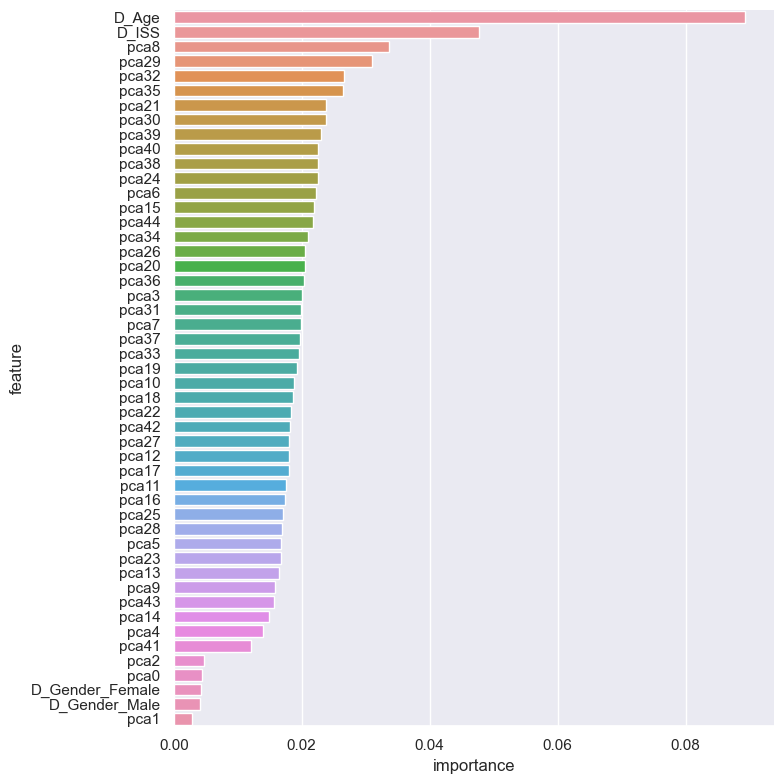

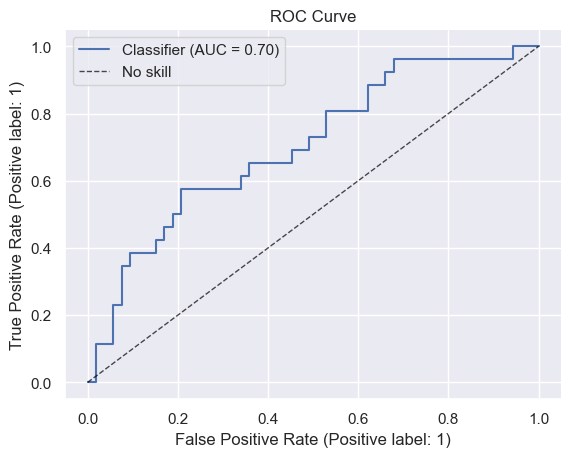

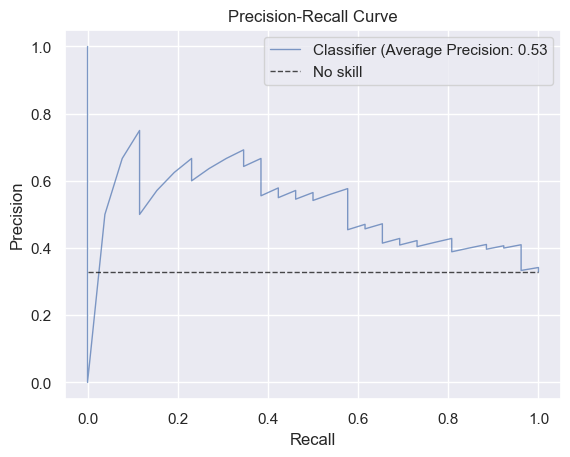

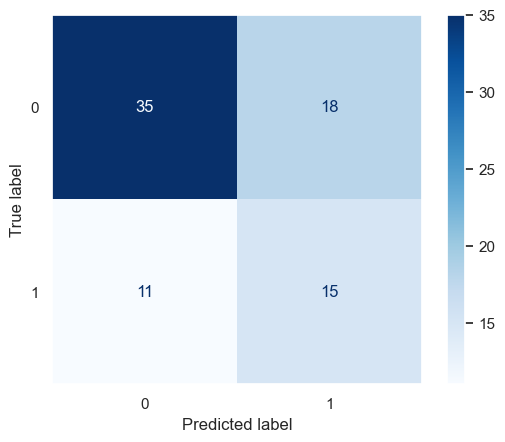

In [18]:
visual.model_evaluation_report(clf_rf_dimred, X_test, y_test)

In [19]:
model_name = 'XGB_dimred'
clf_xgb_dimred = model.load_model(model_date, model_name)
clf_xgb_dimred

Load model from: C:\projects\side_projects\mm_highrisk\models\model_XGB_dimred_2022-11-13.joblib


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('ohe_nominal',
                                                                               OneHotEncoder(sparse=False),
                                                                               ['D_Gender']),
                                                                              ('impute_ordinal',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['D_Age',
                                                                                'D_ISS']),
                                                                              ('pca_continuous',
                                                                               Pipeline(steps=[('remove_constant',
                                                                                                VarianceThreshold(threshold=0)),
                                                                                               ('impute_continuous',
                                                                                                SimpleImputer(...
                   param_distributions={'clf__learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'clf__max_depth': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82,
       87, 92, 97]),
                                        'clf__n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960]),
                                        'preprocess__pca_continuous__pca__n_components': range(5, 200, 5)},
                   scoring='average_precision', verbose=10)

average_precision test data: 0.46012668583531124
roc_auc test data: 0.6494920174165457
balanced_accuracy test data: 0.6650943396226415

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        53
           1       0.59      0.50      0.54        26

    accuracy                           0.72        79
   macro avg       0.68      0.67      0.67        79
weighted avg       0.71      0.72      0.71        79

best params: {'preprocess__pca_continuous__pca__n_components': 165, 'clf__n_estimators': 860, 'clf__max_depth': 27, 'clf__learning_rate': 0.45}


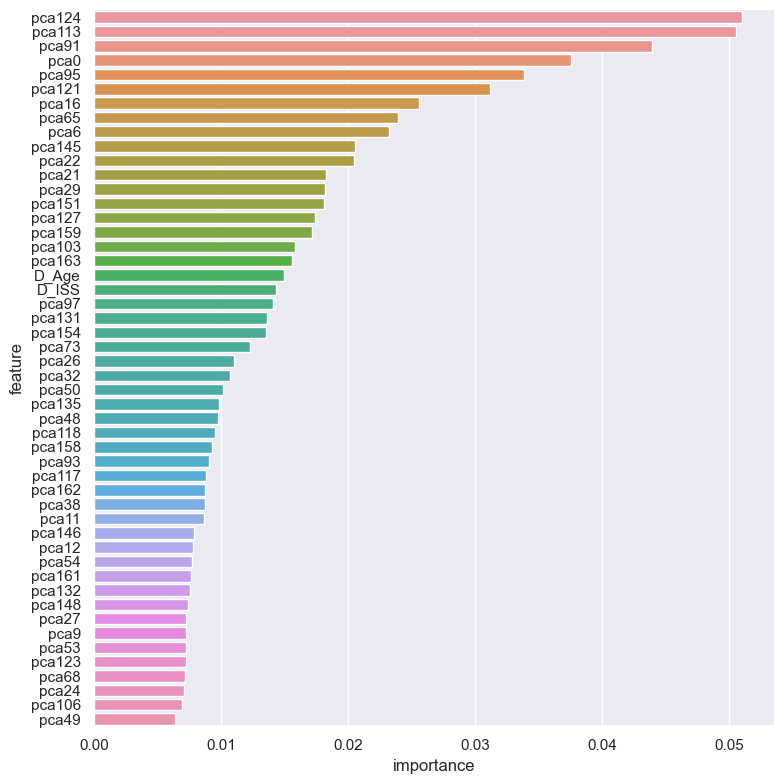

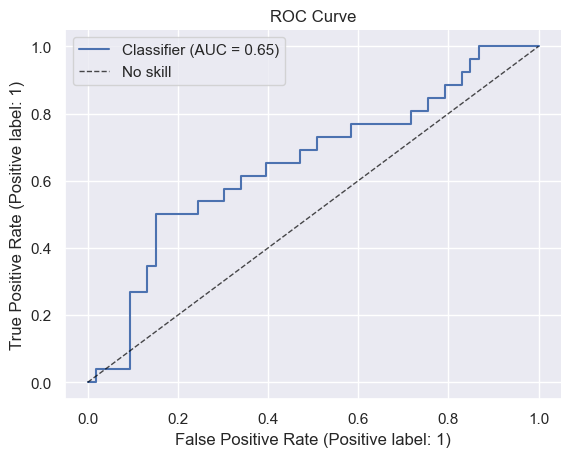

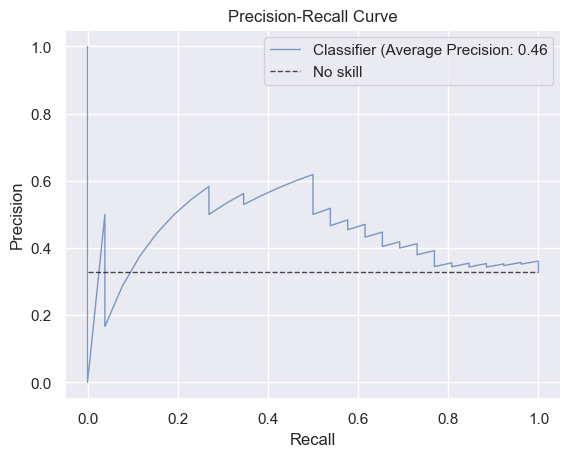

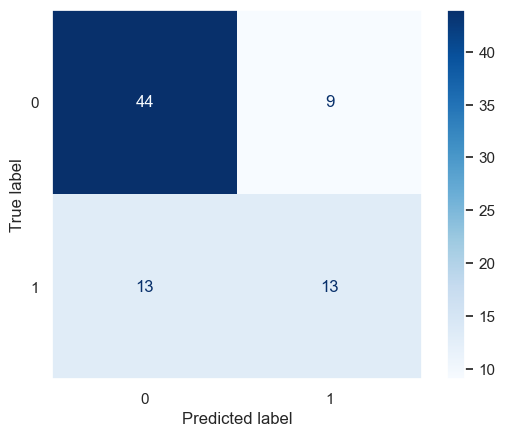

In [20]:
visual.model_evaluation_report(clf_xgb_dimred, X_test, y_test)

## Conclusion
For all three pipelines the Random Forest seems to be performing better than XGBoost, however, these results may vary over multiple runs. Overall the Feature Selection and Dimensionality Reduction pipelines perform best. We favour the Feature Selection pipeline for better model explainability, where the dimensionality reduction pipeline transforms features to principal components. 

The classifier results are far from optimal and could be improved, however, this was not unexpected as the dataset was limited to 392 records and none of the existing features had a strong correlation to the target. However, when comparing our classifiers to the results of the MM DREAM Challenge [3], we see similar performances. 

In this challenge, the models were developed and validated on a larger dataset. Additionally, slightly different and more niche evaluation metrics like Integrated AUC (iAUC) and balanced accuracy curve (BAC) were used. Despite slightly different conditions, we observe that the results are far from optimal as well. Both IAUC and BAC of the article’s top performing classifiers are below 0.7. 
